## With Carbon feedback
Growth control is the main purpose of having a feedback from carbon content on the growth rate.


In [1]:
from CPlantBox_PiafMunch import * #import all the libraries

In [114]:
name = "carbon2020.xml"
plant = pb.Plant()

# 2. A split pot experiment
topBox = pb.SDF_PlantBox(22, 20, 5)
#topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# sideBox = pb.SDF_PlantBox(12, 12, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
sideBox = pb.SDF_PlantBox(10, 20, 35)
left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
box_ = []
box_.append(topBox)
box_.append(left)
box_.append(right)
splitBox = pb.SDF_Union(box_)


# Set geometry: rotatedRhizotron, splitBox, or rhizoTube
plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)

carbon_logger = []
growth_rate_logger = []
exudation_logger = []
root_length_logger = []
all_length_logger = []
taproot_n_all = []
k1_logger = []
leaf_logger = []

In [170]:
taproot_n_all

[[0, 1, 2],
 [0, 2, 4],
 [0, 2, 4],
 [0, 3, 6],
 [0, 5, 10],
 [0, 6, 12],
 [0, 7, 14],
 [0, 7, 14],
 [0, 8, 16],
 [0, 8, 16],
 [0, 8, 16],
 [0, 8, 16],
 [0, 8, 16],
 [0, 9, 18],
 [0, 9, 18],
 [0, 9, 18],
 [0, 9, 18],
 [0, 9, 18],
 [0, 9, 18],
 [0, 10, 20],
 [0, 10, 20],
 [0, 10, 20],
 [0, 10, 20],
 [0, 10, 20],
 [0, 10, 20],
 [0, 10, 20],
 [0, 10, 20],
 [0, 11, 22],
 [0, 11, 22],
 [0, 11, 22],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24],
 [0, 12, 24]]

In [21]:
20.79 + 83.597* 2.71828**(1.39578* (0-0.5)) /100

21.206007461629987

In [143]:
help(organ[-1])
organ[-1].organType()

Help on Leaf in module plantbox object:

class Leaf(Organ)
 |  Method resolution order:
 |      Leaf
 |      Organ
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: plantbox.Leaf, arg0: plantbox.Organism, arg1: int, arg2: plantbox.Vector3d, arg3: float, arg4: plantbox.Organ, arg5: float, arg6: int) -> None
 |      
 |      2. __init__(self: plantbox.Leaf, arg0: int, arg1: plantbox.OrganSpecificParameter, arg2: bool, arg3: bool, arg4: float, arg5: float, arg6: plantbox.Vector3d, arg7: float, arg8: int, arg9: bool, arg10: int) -> None
 |  
 |  calcAge(...)
 |      calcAge(self: plantbox.Leaf, arg0: float) -> float
 |  
 |  calcCreationTime(...)
 |      calcCreationTime(self: plantbox.Leaf, arg0: float) -> float
 |  
 |  calcLength(...)
 |      calcLength(self: plantbox.Leaf, arg0: float) -> float
 |  
 |  dx(...)
 |      d

4

In [169]:
leaf1=int(N1L_node[0][0]-1)
leaf2= int(N1L_node[1][0]-1)
leaf3= int(N1L_node[2][0]-1)
organ[node_id_to_organ[leaf2]].organType()
organ[node_id_to_organ[leaf3]].organType()
organ[0]
node_id_to_organ[leaf1]
for leaf in N1L_node:
    leaf_nb = int(leaf[0]-1)
    print(organ[node_id_to_organ[leaf_nb]].getLength())


1.9840525870552153
1.9869479190372135
4.981510681417586


In [167]:
# growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
# absolute respiration maintenance of plant segment = volumen of the segment
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for i in range(1,2): # i*days to simulation
    plant.setGeometry(splitBox)
    day = 1 # the step of every loop (day)
    hour =24 # the hours of every loop (hour) used in PiafMunch
    plant.simulate(day) # start simulation
    organ = plant.getOrgans()
    plant.write("{}{}{}.vtp".format("only_Q_ST_test",str(name),i*day)) #writes vtp the name is followed by the number of days simulated
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    Seg_radius = [0]*((len(organ))+1) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    node_id_to_organ = [0]*plant.getNumberOfNodes() #
    
    ###########
    r_k1 = 1e-4 # magnitude midification, because the realistic value in literature need to be found
    ###########
    
    k = 0
    ########################################## python nodes conversion #########################################
    
    nodes_organtype = dict_all['nodes_organtype']
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
    # source nodes
    N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
    leaf_logger.append(len(N1L_node))
    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    
    for k in reversed(range(len(organ))):  # get all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of root
        j=0
        for j in range(1,organ[k].getNumberOfNodes()): # get all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
            Carbon_main = Seg_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx *0.0032/(24)*0.2/4200 # calculate the maintenance by volume 4200 is the number of phloem
            #Carbon_main = 1
            # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main
    k1_logger.append(np.sum(k1))
    taproot_length = [0] * (len(plant.getOrgans())+1)
    all_organ_length = [0] * (len(plant.getOrgans())+1)
    taproot_n = []
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
            Soil_water[j] = 0.5
        elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
            Soil_water[j] = 0.5
        elif j == taproot_n[2] or organ_i.getParent().getId() == 3:
            Soil_water[j] = 0.5  
        else:
            Soil_water[j] = 0.5
        
        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    ################################# coupling layer with piafmunch ###################################################
    homo_st = [20]*(len(dict_all["node_connection"]))
    # pass the absolute carbon maintentance to piafmunch
    write_PiafMunch_parameter(dict_all['node_connection'], dict_all['nodes_organtype'], homo_st, dict_all['unq_cnt'], Soil_water, k1, piafmunch_outputname,hour)
    # call piafmunch and rename the output file of the PiafMunch
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
    now = datetime.datetime.now()
    os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
    ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_growth_log = [0] * (len(plant.getOrgans())+1)
    one_carbon_log = [0] * (len(plant.getOrgans())+1)
    one_exudation_log = [0] * (len(plant.getOrgans())+1)
    for node_i,node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(node[0])-1]]
        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumn # directly pass the Q_ST * 1e5 to carbon content
        num_of_phloem = 4200/0.12566370400000001
       
        carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 *24 *num_of_phloem /0.1/0.2
        print("available carbon: ", carbon_content )
        print(node_id_to_organ[int(node[0])-1])
        
        
        
        water_potential = g_propotion(0-Soil_water[node_i])
        if i == 1:
            r_water =  water_potential * nodes_organ.getParam().r
        else: 
            r_water =  nodes_organ.getParam().r
        print("waterpotebtial", water_potential)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        nodes_organ.getParam().r =   max([0, min([r_water, carbon_content])])
        
        print("growth rate", nodes_organ.getParam().r)
        one_carbon_log[node_id_to_organ[int(node[0])-1]] = carbon_content
        one_growth_log[node_id_to_organ[int(node[0])-1]] = nodes_organ.getParam().r
        one_exudation_log[node_id_to_organ[int(node[0])-1]] = max([0,carbon_content - r_water])  
  #  print(plant.getSeed().getNumberOfChildren())
    growth_rate_logger.append(one_growth_log)
    carbon_logger.append(one_carbon_log)
    exudation_logger.append(one_exudation_log)
    ############################################length logger ###########################
    

    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
            all_organ_length[root_n] = root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: #make sure it is taproot: 
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
            all_organ_length[root_n] = root.getLength()
    root_length_logger.append(taproot_length)
    all_length_logger.append(all_organ_length)
#     f=np.sum
    
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
#     f.legend()
#     f.show()
#     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

#change the soil water


output successful
available carbon:  1.2531687272245289
1
waterpotebtial 0.623907461629989
growth rate 0.7810235466949521
available carbon:  1.2531687272245289
13
waterpotebtial 0.623907461629989
growth rate 0.7810235466949521
available carbon:  1.2531687272245289
25
waterpotebtial 0.623907461629989
growth rate 0.7810235466949521
available carbon:  1.0570356449146205
2
waterpotebtial 0.623907461629989
growth rate 0.6585465534400484
available carbon:  1.0570356449146205
14
waterpotebtial 0.623907461629989
growth rate 0.6585465534400484
available carbon:  1.0570356449146205
26
waterpotebtial 0.623907461629989
growth rate 0.6585465534400484
available carbon:  0.8794416437064435
3
waterpotebtial 0.623907461629989
growth rate 0.5475761758111326
available carbon:  0.8794416437064435
15
waterpotebtial 0.623907461629989
growth rate 0.5475761758111326
available carbon:  0.8794416437064435
27
waterpotebtial 0.623907461629989
growth rate 0.5475761758111326
available carbon:  0.7216188120636647
4


In [55]:
k1_logger

[5.831160068624445e-09, 9.683254907263867e-09]

get the potential growth rate





1:23
get the demand in carbon based on potential growth
1:24
get the offer in carbon based in piaf munch
1:24
make the ration between the two
1:24
= C_satistafction_coef
1:25
water_satisfaction_coef
1:25
from the experimental fitting
1:25
GR_act = GR_pot * C_satis * W_satis
1:26
1 > C_satis > 0
1:26
1 > W_satis > 0
1:27
GR_pot_2 = GR_pot * W_satis
1:29
C_demand_2 = GR_pot_2 * density
1:29
C_satis = C_offer_2 / C_demand_2 (edited) 
1:29
GR_act = GR_pot_2 * C_satis

guillaume  1:36 PM
if(C_offer > C_demand_2) C_offer_2 = C_demand_2
1:36
C_exudation = C_offer_2 - C_demand_2

In [27]:
print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])

3.92411e-06
3.92411e-06
3.92411e-06


In [88]:
plt(x,g_propotion)

TypeError: 'module' object is not callable

In [28]:
N1R_node

array([[69.,  2.,  1.,  1.],
       [71.,  2.,  1.,  1.],
       [73.,  2.,  1.,  1.],
       [80.,  2.,  1.,  1.],
       [81.,  2.,  1.,  1.],
       [82.,  2.,  1.,  1.]])

In [69]:
all_length_logger

[[1.9752070377333908, 1.9752070377333908, 1.9752070377333908, 0, 0, 0],
 [3.1827712149692466,
  0.629652556412449,
  3.1827712149692466,
  0.629652556412449,
  3.1827712149692466,
  0.629652556412449,
  0,
  0,
  0],
 [4.371646316761497,
  1.5623116012926888,
  4.371646316761497,
  1.5623116012926888,
  4.371646316761497,
  1.5623116012926888,
  0,
  0,
  0,
  0],
 [5.54212158781243,
  2.1279979070708546,
  0.8980363569438082,
  5.54212158781243,
  2.1279979070708546,
  0.8980363569438082,
  5.54212158781243,
  2.1279979070708546,
  0.8980363569438082,
  0,
  0,
  0,
  0],
 [6.694481796278771,
  2.471103995304888,
  1.7250946048851576,
  1.0507173357720303,
  0.002584964778586496,
  6.694481796278771,
  2.471103995304888,
  1.7250946048851576,
  1.0507173357720303,
  0.002584964778586496,
  6.694481796278771,
  2.471103995304888,
  1.7250946048851576,
  1.0507173357720303,
  0.002584964778586496,
  0,
  0,
  0,
  0],
 [7.660344214047852,
  2.6780700516521403,
  2.1882112912222755,
  1.

In [265]:
N1R_node

array([[142.,   2.,   1.,   1.],
       [144.,   2.,   1.,   1.],
       [146.,   2.,   1.,   1.]])

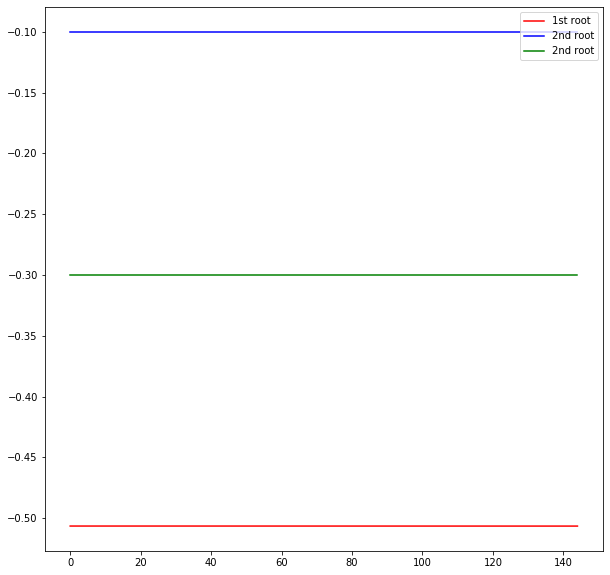

In [9]:
f=plt

f.plot(piaf_output["P_Xyl"][:,int(N1R_node[0][0]-1)-1], color = "red", label = "1st root")
f.plot(piaf_output["P_Xyl"][:,int(N1R_node[1][0]-1)-1], color = "blue", label = "2nd root")
f.plot(piaf_output["P_Xyl"][:,int(N1R_node[2][0]-1)-1], color = "green", label = "2nd root")
f.legend()

In [ ]:
f=plt

f.plot(piaf_output["P_Xyl"][:,int(N1R_node[0][0]-1)-1], color = "red", label = "1st root")
f.plot(piaf_output["P_Xyl"][:,int(N1R_node[1][0]-1)-1], color = "blue", label = "2nd root")
f.plot(piaf_output["P_Xyl"][:,int(N1R_node[2][0]-1)-1], color = "green", label = "2nd root")
f.legend()

In [214]:
homo_st = [20]*(len(dict_all["node_connection"])+1)

In [164]:
plant.getOrgans()[2].getNumberOfNodes()

43

In [54]:
carbon_logger

[[0.01061829216, 0.01061829216, 0.01061829216, 0, 0, 0],
 [0.005288758271999998,
  0.005329509696,
  0.005288758271999998,
  0.005329509696,
  0.005288758271999998,
  0.005329509696,
  0,
  0,
  0],
 [0.007941435263999999,
  0.007986033216000001,
  0.007941435263999999,
  0.007986033216000001,
  0.007941435263999999,
  0.007986033216000001,
  0,
  0,
  0,
  0]]

In [22]:
root

In [55]:
root_length_logger

[[1.9752070377333908, 1.9752070377333908, 1.9752070377333908, 0, 0, 0],
 [2.6758993464762604,
  0,
  2.6758993464762604,
  0,
  2.6758993464762604,
  0,
  0,
  0,
  0],
 [2.6861399992239, 0, 2.6861399992239, 0, 2.6861399992239, 0, 0, 0, 0, 0]]

In [57]:
root_he_c1 
root_he_l1 

In [87]:
exudation_logger 

[[2.977021231497961, 2.977021231497961, 2.977021231497961, 0, 0, 0],
 [0.8175263052621411,
  0.6594371720890857,
  0.8175263052621411,
  0.6594371720890857,
  0.8175263052621411,
  0.6594371720890857,
  0,
  0,
  0]]

In [75]:
ccc.shape

(39,)

No handles with labels found to put in legend.


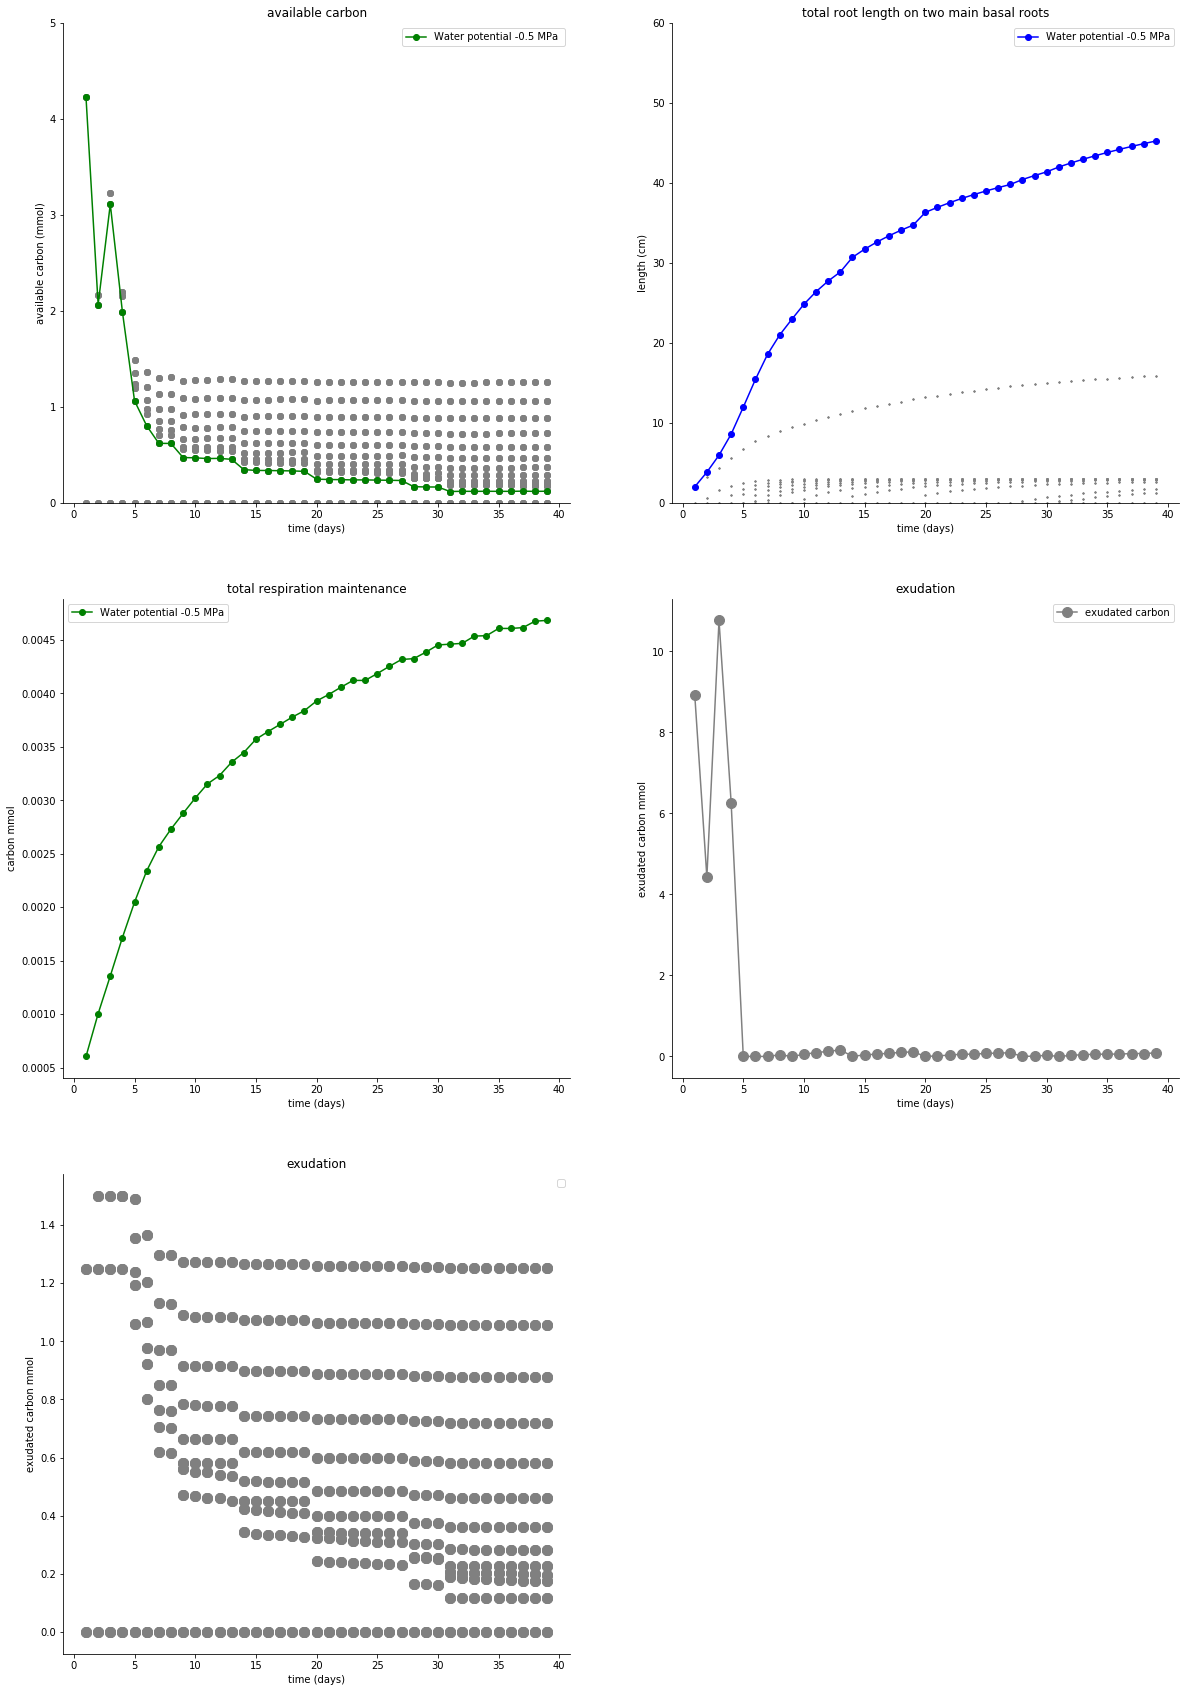

In [118]:

root_he_c3 = []
root_he_l3 = []
root_he_c3 = carbon_logger
root_he_l3 = root_length_logger
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
root_3_l_cf = []
root_3_c_cf = []

growth_rate_logger 
exudation_logger 

for i, length_i in enumerate(root_he_l3):
    root_1_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][2]])
    root_1_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][2]])
fig = plt.figure(figsize=(20,30))    
ax1 = fig.add_subplot(3, 2, 1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
days = range(1,len(carbon_logger)+1)
# ax1.plot(days,root_1_c_cf, marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
# ax1.plot(days,root_2_c_cf, marker = "o", linestyle="-", color = "red", label= "Water potential -0.3 MPa ", zorder=99)
ax1.plot(days,root_3_c_cf, marker = "o", linestyle="-", color = "green", label= "Water potential -0.5 MPa ", zorder=2)
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    ax1.plot(x,carbon_logger[i], marker = "o", linestyle="", color = "grey", zorder=1)
ax1.title.set_text("available carbon")
ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()


ccc = np.squeeze(np.array(all_length_logger))
ax2 = fig.add_subplot(3, 2, 2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")
ax2.plot(days, root_3_l_cf, color= "blue", marker = "o", label= "Water potential -0.5 MPa")
for i, day in enumerate(all_length_logger):
    x = [i+1]*len(day)
    ax2.plot(x,day, marker = "o", linestyle="", color = "grey", zorder=1, markersize=1)
ax2.legend()
ax2.title.set_text("total root length on two main basal roots")
ax2.set_xlabel("time (days)")
ax2.set_ylabel("length (cm)")
ax2.set_ylim([0,60])
#ax2.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

def f(x):
    # return multiply *4200*24
    return x *4200*24

ax3 = fig.add_subplot(3, 2, 3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax3.plot(days, f(np.array(k1_logger)), color= "green", marker = "o", label= "Water potential -0.5 MPa")
ax3.legend()
ax3.title.set_text("total respiration maintenance")
ax3.set_xlabel("time (days)")
ax3.set_ylabel("carbon mmol")
#ax3.set_ylim([0,60])
#ax3.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

total_exudation = []
for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax4 = fig.add_subplot(3, 2, 4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

# for i, root_tip in enumerate(exudation_logger):
#     x = [i+1]*len(root_tip)
ax4.plot(days,total_exudation , marker = "o", linestyle="-", color = "grey", zorder=1, markersize=10, label = "exudated carbon")
ax4.legend()
ax4.title.set_text("exudation")
ax4.set_xlabel("time (days)")
ax4.set_ylabel("exudated carbon mmol")
# ax4.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')


for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax5 = fig.add_subplot(3, 2, 5)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

for i, root_tip in enumerate(growth_rate_logger):
    x = [i+1]*len(root_tip)
    ax5.plot(x,root_tip , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax5.legend()
ax5.title.set_text("growth rate")
ax5.set_xlabel("time (days)")
ax5.set_ylabel("growth rate cm/day")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])

ax6 = fig.add_subplot(3, 2, 6)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

for i, root_tip in enumerate(growth_rate_logger):
    x = [i+1]*len(root_tip)
    ax6.plot(x,root_tip , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax6.legend()
ax6.title.set_text("leaf number")
ax6.set_xlabel("days")
ax6.set_ylabel("leaf number")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

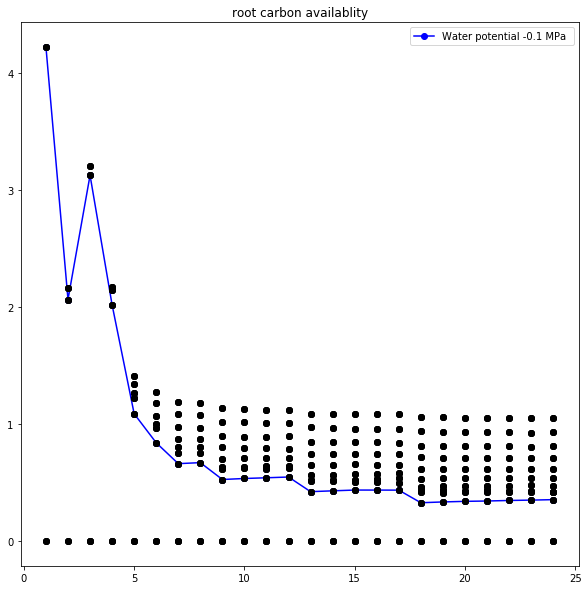

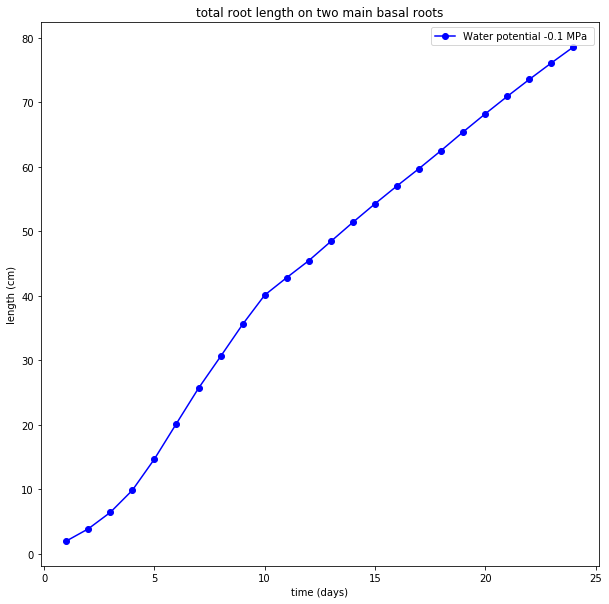

In [7]:
root_he_c3 = carbon_logger
root_he_l3 = root_length_logger
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
root_3_l_cf = []
root_3_c_cf = []

for i, length_i in enumerate(root_he_l3):
    root_1_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][2]])
    root_1_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][2]])
f1 = plt    
days = range(1,len(carbon_logger)+1)
f1.plot(days,root_1_c_cf, marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ")
# f1.plot(days,root_2_c_cf, marker = "o", linestyle="-", color = "red", label= "Water potential -0.3 MPa ")
# f1.plot(days,root_3_c_cf, marker = "o", linestyle="-", color = "green", label= "Water potential -0.5 MPa ")
plt.title("root carbon availablity")
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    f1.plot(x,carbon_logger[i], marker = "o", linestyle="", color = "black")
f1.legend()
f1.savefig(fname= 'growth rate2 ')

fig,f2=plt.subplots(1)
f2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# f2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")
# f2.plot(days, root_3_l_cf, color= "green", marker = "o", label= "Water potential -0.5 MPa")
f2.legend()
plt.title("total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

fig.savefig(fname= 'length2 ')

In [202]:
len(dict_all["nodes_r_st"])

172

In [209]:
len(homo_st)

173

In [177]:
help(plant.getOrgans()[2])

Help on Root in module plantbox object:

class Root(Organ)
 |  Method resolution order:
 |      Root
 |      Organ
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: plantbox.Root, arg0: plantbox.Organism, arg1: int, arg2: plantbox.Vector3d, arg3: float, arg4: plantbox.Organ, arg5: float, arg6: int) -> None
 |      
 |      2. __init__(self: plantbox.Root, arg0: int, arg1: plantbox.OrganSpecificParameter, arg2: bool, arg3: bool, arg4: float, arg5: float, arg6: plantbox.Vector3d, arg7: float, arg8: int, arg9: bool, arg10: int) -> None
 |  
 |  calcAge(...)
 |      calcAge(self: plantbox.Root, arg0: float) -> float
 |  
 |  calcCreationTime(...)
 |      calcCreationTime(self: plantbox.Root, arg0: float) -> float
 |  
 |  calcLength(...)
 |      calcLength(self: plantbox.Root, arg0: float) -> float
 |  
 |  dx(...)
 |      d

In [168]:
dict_all['nodes_r_st'][164]

26.598843597174834

In [172]:
dict_all['nodes_r_st'][168]

26.550498376146187

In [244]:
dict_all['nodes_r_st'][172]

IndexError: index 172 is out of bounds for axis 0 with size 79

Text(0, 0.5, 'length (cm)')

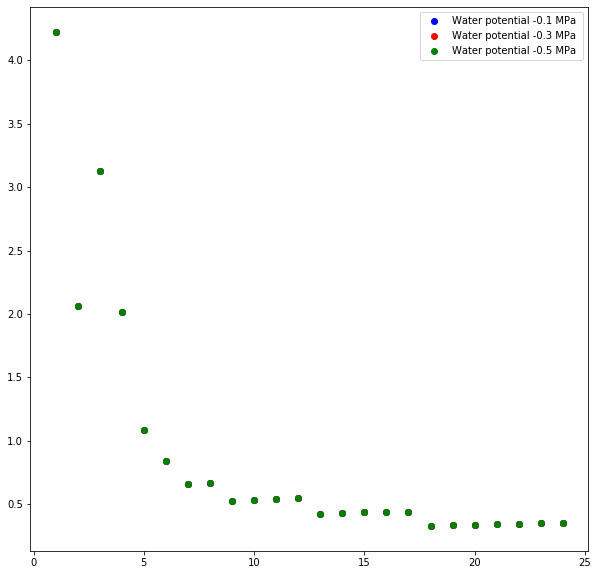

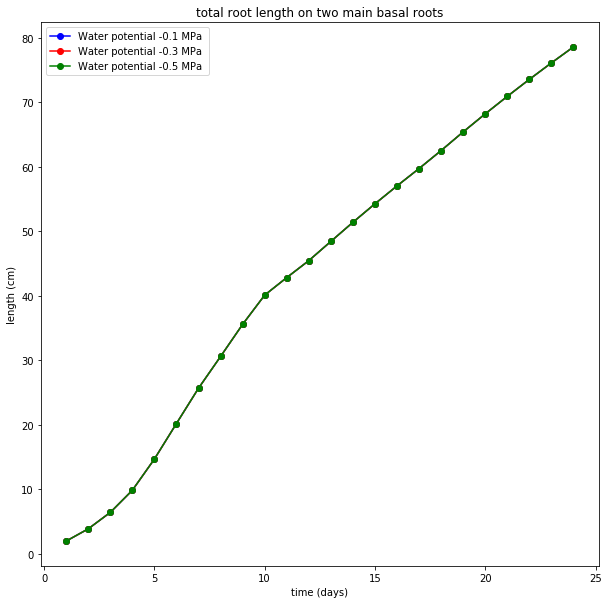

In [6]:
root_he_c = carbon_logger
root_he_l = root_length_logger
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
root_3_l_cf = []
root_3_c_cf = []

for i, length_i in enumerate(root_he_l):
    root_1_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][1]])
    root_3_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][2]])
    root_1_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][1]])
    root_3_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][2]])
f1 = plt    
days = range(1,len(carbon_logger)+1)
f1.plot(days,root_1_c_cf, marker = "o", linestyle="", color = "blue", label= "Water potential -0.1 MPa ")
f1.plot(days,root_2_c_cf, marker = "o", linestyle="", color = "red", label= "Water potential -0.3 MPa ")
f1.plot(days,root_3_c_cf, marker = "o", linestyle="", color = "green", label= "Water potential -0.5 MPa ")
f1.legend()

fig,f2=plt.subplots(1)
f2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
f2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")
f2.plot(days, root_3_l_cf, color= "green", marker = "o", label= "Water potential -0.5 MPa")
f2.legend()
plt.title("total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

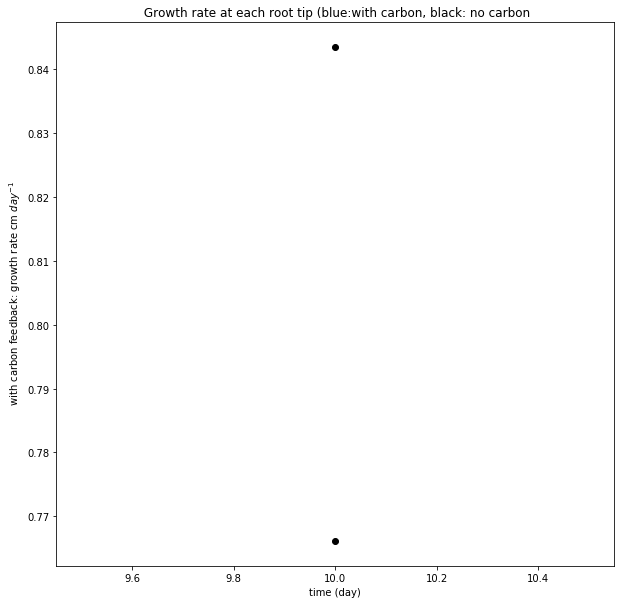

In [73]:


f1=plt
f1.title(" Growth rate at each root tip (blue:with carbon, black: no carbon")
#for i, day in enumerate(carbon_logger):
x = [i+1]*len(day)
f1.plot(x,carbon_logger[i], marker = "o", linestyle="", color = "black")
f1.ylabel(" with carbon feedback: growth rate cm $day^{-1}$")
f1.xlabel("time (day)")
x = range(1,len(day))
f1.plot(x,root_he_c[0], marker = "o", linestyle="", color = "blue")
f1.plot(x,root_he_c[1], marker = "o", linestyle="", color = "red")
#a1 = f1.plot(days1, root_1_c_cf, color= "blue", marker = "v", label= "Carbon feedback dry basal root ")
#a2 = f1.plot(days1, root_2_c_cf, color= "red", marker = "v", label= "Carbon feedback wet basal root")
f1.legend()




In [11]:
root_length_logger

[]

1.9948599999999997e-05
0
1.96966e-05
1


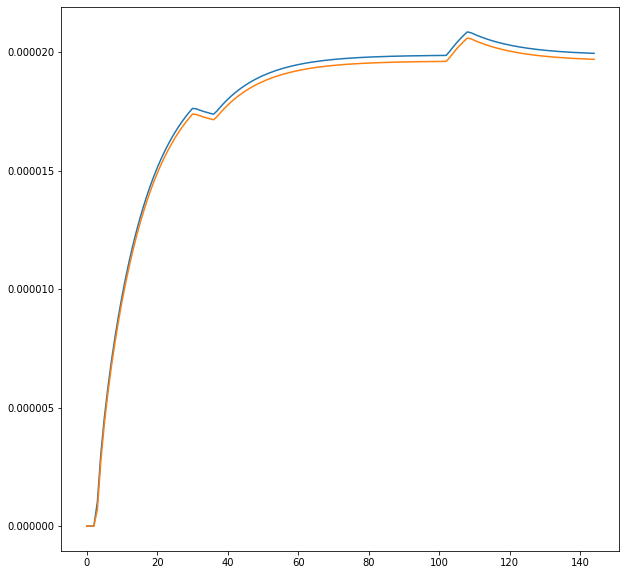

In [13]:
f=plt
for i in N1R_node:
    f.plot(piaf_output["Q_ST"][:,int(i[0]-1)])
    print(piaf_output["Q_ST"][-1,int(i[0]-1)])
    print(node_id_to_organ[int(i[0]-1)])

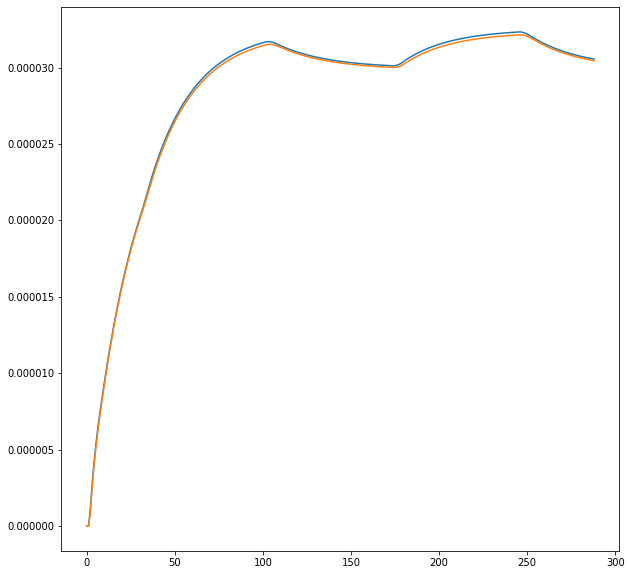

In [22]:
f=plt
f.plot(piaf_output["Q_ST"][:,3])
f.plot(piaf_output["Q_ST"][:,4])
f.show()

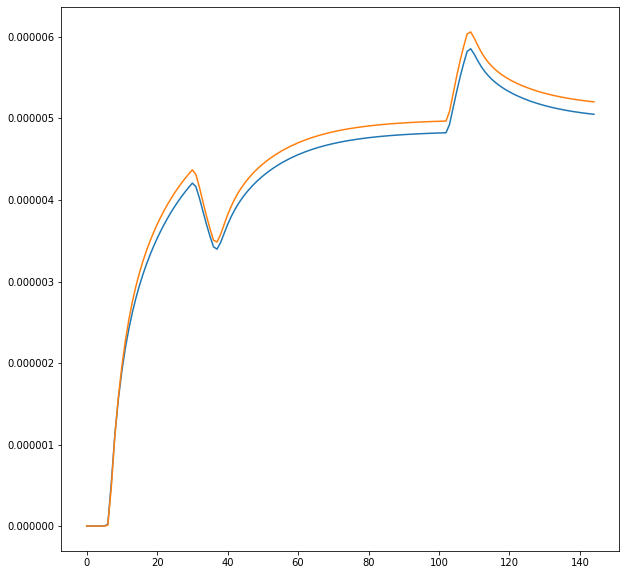

In [595]:
f=plt
f.plot(piaf_output["Q_ST"][:,464])
f.plot(piaf_output["Q_ST"][:,463])

No handles with labels found to put in legend.


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

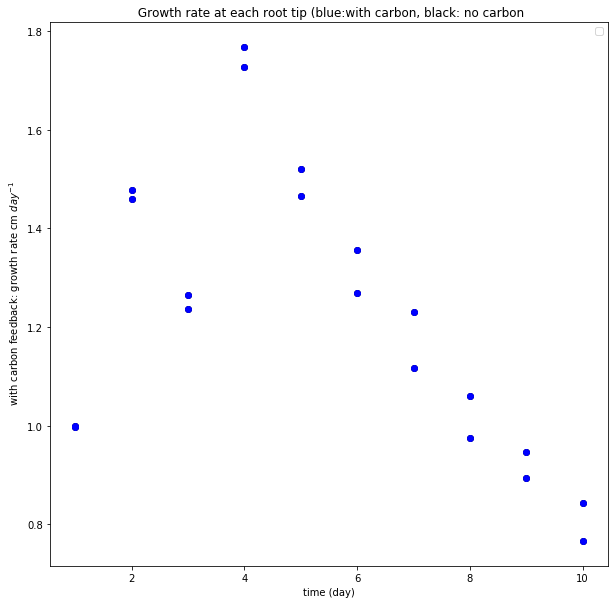

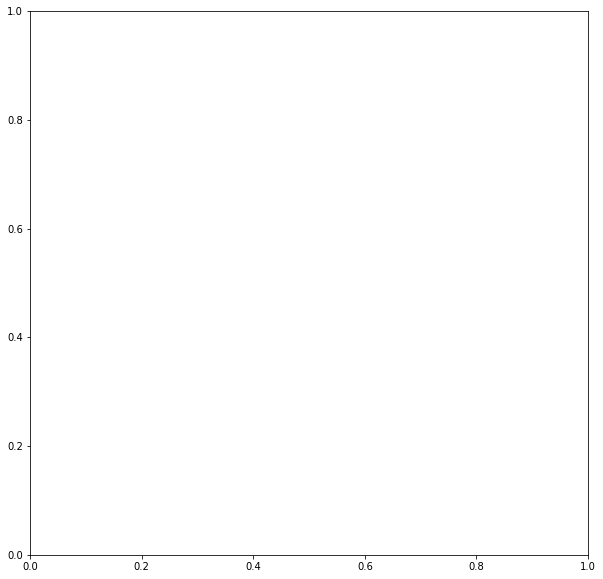

In [71]:
root_he_c = carbon_logger

f1=plt
f1.title(" Growth rate at each root tip (blue:with carbon, black: no carbon")
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    f1.plot(x,carbon_logger[i], marker = "o", linestyle="", color = "black")
f1.ylabel(" with carbon feedback: growth rate cm $day^{-1}$")
f1.xlabel("time (day)")
for i, day in enumerate(root_he_c):
    x = [i+1]*len(day)
    f1.plot(x,root_he_c[i], marker = "o", linestyle="", color = "blue")
#a1 = f1.plot(days1, root_1_c_cf, color= "blue", marker = "v", label= "Carbon feedback dry basal root ")
#a2 = f1.plot(days1, root_2_c_cf, color= "red", marker = "v", label= "Carbon feedback wet basal root")
f1.legend()



In [91]:
organ[0].get

AttributeError: 'plantbox.Root' object has no attribute 'get'

In [598]:
node_id_to_organ[462]

0

In [529]:
organ[0].calcLength()

AttributeError: 'plantbox.Plant' object has no attribute 'calcLength'

In [570]:
N1R_node[:,-4]

AttributeError: 'numpy.ndarray' object has no attribute 'int'

In [594]:
N1R_node[9]

array([464.,   2.,   1.,   1.])

In [495]:
organ[0].getParent().getId()

0

In [422]:
    for k in range(0, len(organ)):  # get all the organs
        j=0
        for j in range(0, organ[k].getNumberOfNodes()): # get all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k

In [ ]:
root_length_logger

In [ ]:
node_id_to_organ

In [533]:
organ[0].getChild(10)

In [ ]:
carbon_logger

NameError: name 'carbon_logger' is not defined

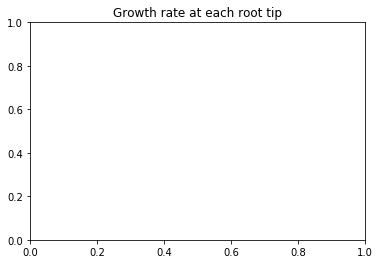

In [3]:
f1=plt
f1.title("Growth rate at each root tip")
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    f1.plot(x,carbon_logger[i], marker = "o", linestyle="")
f1.ylabel(" with carbon feedback: growth rate cm $day^{-1}$")
f1.xlabel("time (day)")
a1 = f1.plot(days1, root_1_c_cf, color= "blue", marker = "P", label= "Carbon feedback 1 basal root ", markersize = "20")
a2 = f1.plot(days1, root_2_c_cf, color= "red", marker = "P", label= "Carbon feedback 2 basal root", markersize = "20")
f1.legend()

In [4]:
root_ho_c = carbon_logger
root_ho_l = root_length_logger

NameError: name 'carbon_logger' is not defined

In [ ]:
root_ho_l

In [70]:
import matplotlib.patches as patches
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
for i, length_i in enumerate(root_ho_l):
    root_1_l_cf.append(length_i[np.array(root_ho_l[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_ho_l[i]).nonzero()[0][1]])
    root_1_c_cf.append(root_ho_c[i][np.array(root_ho_l[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_ho_c[i][np.array(root_ho_l[i]).nonzero()[0][1]])
    
    
days1 = range(1,47)
# days1 = [1,2,3,4,5,6,7,8,9]
# days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]


fig,f2=plt.subplots(1)
f2.plot(days1, root_1_l_cf, color= "blue", marker = "o", label= "basal root1 ")
f2.plot(days1, root_2_l_cf, color= "red", marker = "o", label= "basal root2 ")
f2.legend()
plt.title("total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

# f2.add_patch(
#      patches.Rectangle(
#         (0.0, 0),
#         9,
#         23,
#         fill=False, color="purple" , label = "homogeneous soil water"     # remove background
#      ) ) 
# f2.text(3,27,"homogeneous \n soil water", color = "purple")


# f2.add_patch(
#      patches.Rectangle(
#         (9, 23),
#         19,
#         38,
#         fill=False, color="orange" , label = "homogeneous soil water"     # remove background
#      ) ) 
# f2.text(19,19,"heterogenous \n soil water \n red -0.5 MPa \ blue -0.1 MPa", color = "orange")

NameError: name 'root_ho_l' is not defined

Text(19, 19, 'heterogenous \n soil water \n red -0.5 MPa \\ blue -0.1 MPa')

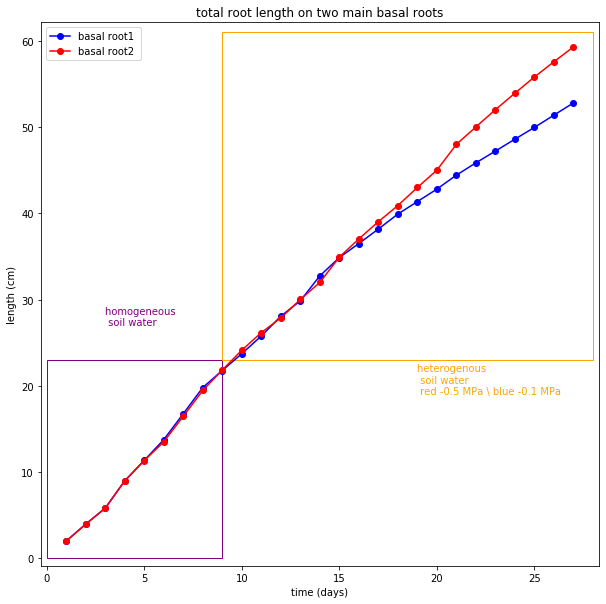

In [366]:
import matplotlib.patches as patches
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
for i, length_i in enumerate(root_he_l):
    root_1_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][1]])
    root_1_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][1]])
    
    
# days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
days1 = [1,2,3,4,5,6,7,8,9]
days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
fig,f2=plt.subplots(1)
f2.plot(days1, root_1_l_cf, color= "blue", marker = "o", label= "basal root1 ")
f2.plot(days1, root_2_l_cf, color= "red", marker = "o", label= "basal root2 ")
f2.legend()
plt.title("total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

f2.add_patch(
     patches.Rectangle(
        (0.0, 0),
        9,
        23,
        fill=False, color="purple" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(3,27,"homogeneous \n soil water", color = "purple")


f2.add_patch(
     patches.Rectangle(
        (9, 23),
        19,
        38,
        fill=False, color="orange" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(19,19,"heterogenous \n soil water \n red -0.5 MPa \ blue -0.1 MPa", color = "orange")

In [332]:
root_noc_c = carbon_logger
root_noc_l = root_length_logger

In [ ]:
root_he_c
root_he_l

In [226]:
root_3_l = root_length_logger

In [223]:
f=plt
f.plot(piaf_output["Q_ST"][:,8])
f.plot(piaf_output["Q_ST"][:,16])

[[0, 0, 0, 0, 0],
 [0.6900076905179044, 0, 0.6900076905179044, 0, 0, 0, 0, 0],
 [1.6238068459715733, 0, 1.6204350662911853, 0, 0, 0, 0, 0],
 [3.8668197871612557, 0, 0, 0, 3.8647867981235398, 0, 0, 0, 0, 0, 0, 0, 0]]

In [87]:
g_propotion(0-0.2)


(0.1794622100754001-0.08372893500033934j)

# No carbon feedback

In [312]:
name = "carbon2020.xml"
plant = pb.Plant()

# 2. A split pot experiment
topBox = pb.SDF_PlantBox(22, 20, 5)
#topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# sideBox = pb.SDF_PlantBox(12, 12, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
sideBox = pb.SDF_PlantBox(10, 20, 35)
left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
box_ = []
box_.append(topBox)
box_.append(left)
box_.append(right)
splitBox = pb.SDF_Union(box_)


# Set geometry: rotatedRhizotron, splitBox, or rhizoTube
plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)

carbon_logger = []
root_length_logger = []
taproot_n_all = []

In [313]:


# absolute respiration maintenance of plant segment = volumen of the segment
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for i in range(1,10): # how many i*days to simulation
    plant.setGeometry(splitBox)
    day = 1 # the step of every loop (day)
    hour = 24 # the hour of every loop (hour) used in PiafMunch
    plant.simulate(day) # start simulation
    organ = plant.getOrgans()
    plant.write("{}{}{}.vtp".format("only_Q_ST_test",str(name),i*day)) #writes vtp the name is followed by the number of days simulated
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    Seg_radius = [0]*((len(organ))+1) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    node_id_to_organ = [0]*plant.getNumberOfNodes() #
    r_k1 = 1e-9 # magnitude midification, because the realistic value in literature need to be found
    k = 0
    ########################################## python nodes conversion #########################################
    
    nodes_organtype = dict_all['nodes_organtype']
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & (nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # no seed, root, one connection
    # source nodes
    N1L_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # no seed, stem or leaf, one connection

    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    
    for k in range(0, len(organ)):  # get all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of root
        j=0
        for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
            Carbon_main = Seg_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx *r_k1 # calculate the maintenance by volume 
            # Carbon_main = 0
            # print(Carbon_main)  absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main
    
    taproot_length = [0] * (len(plant.getOrgans())+1)
    taproot_n =[]
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
            Soil_water[j] = 0.1
        elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
            Soil_water[j] = 0.1        
        
        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    ################################# coupling layer with piafmunch ###################################################
    
#     # pass the absolute carbon maintentance to piafmunch
#     write_PiafMunch_parameter(dict_all['node_connection'], dict_all['nodes_organtype'], dict_all['nodes_r_st'], dict_all['unq_cnt'], Soil_water, k1, piafmunch_outputname,hour)
#     # call piafmunch and rename the output file of the PiafMunch
#     os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
#     now = datetime.datetime.now()
#     os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
#     ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_carbon_log = []
    for i in N1R_node: # CPlantBox growth rate: cm day-1
        # print(i)
        carbon_content = piaf_output["Q_ST"][-1][int(i[0])-1]* 1e5 # directly pass the Q_ST * 1e5 to carbon content
        one_carbon_log.append(organ[node_id_to_organ[int(i[0])-1]].getParam().r)
        #organ[node_id_to_organ[int(i[0])-1]].getParam().r =         carbon_content 
  #  print(plant.getSeed().getNumberOfChildren())
    carbon_logger.append(one_carbon_log)
    ############################################length logger ###########################
    

    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: #make sure it is taproot: 
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
    root_length_logger.append(taproot_length)

 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

Text(19, 19, 'heterogenous \n soil water \n red -0.5 MPa \\ blue -0.1 MPa')

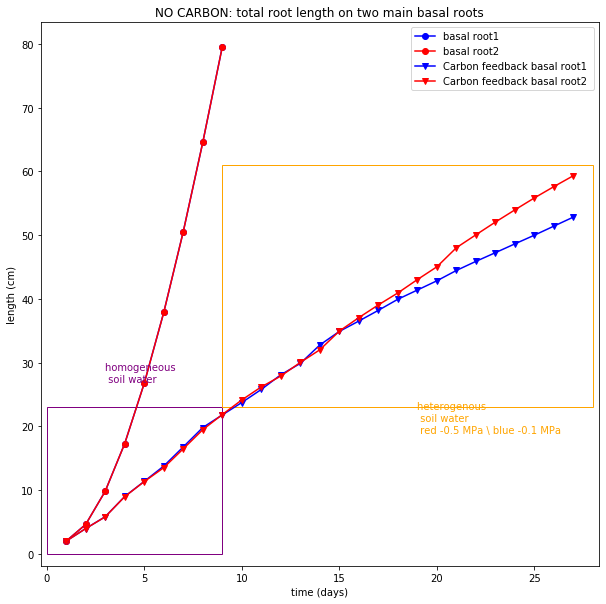

In [324]:
import matplotlib.patches as patches
root_1_l = []
root_2_l = []
for i, length_i in enumerate(root_length_logger):
    root_1_l.append(length_i[np.array(root_length_logger[i]).nonzero()[0][0]])
    root_2_l.append(length_i[np.array(root_length_logger[i]).nonzero()[0][1]])

days = [1,2,3,4,5,6,7,8,9]


fig,f2=plt.subplots(1)
f2.plot(days, root_1_l, color= "blue", marker = "o", label= "basal root1 ")
f2.plot(days, root_2_l, color= "red", marker = "o", label= "basal root2 ")
f2.legend()
plt.title("NO CARBON: total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
f2.plot(days1, root_1_l_cf, color= "blue", marker = "v", label= "Carbon feedback basal root1 ")
f2.plot(days1, root_2_l_cf, color= "red", marker = "v", label= "Carbon feedback basal root2 ")
f2.legend()


f2.add_patch(
     patches.Rectangle(
        (0.0, 0),
        9,
        23,
        fill=False, color="purple" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(3,27,"homogeneous \n soil water", color = "purple")


f2.add_patch(
     patches.Rectangle(
        (9, 23),
        19,
        38,
        fill=False, color="orange" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(19,19,"heterogenous \n soil water \n red -0.5 MPa \ blue -0.1 MPa", color = "orange")


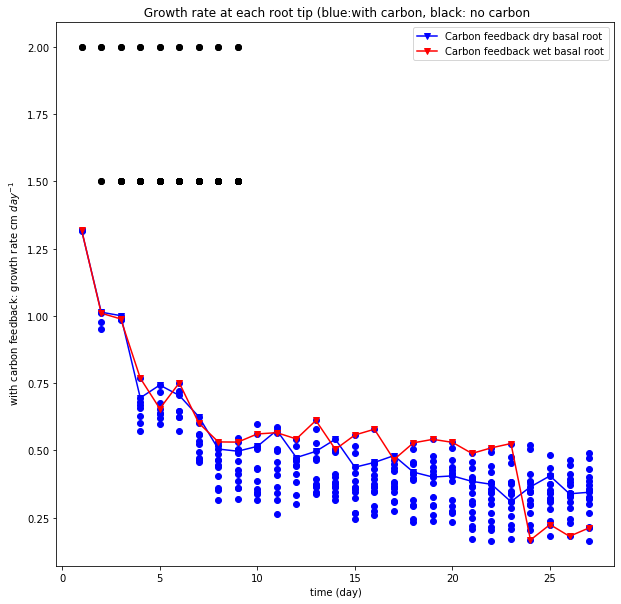

In [343]:
f1=plt
f1.title(" Growth rate at each root tip (blue:with carbon, black: no carbon")
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    f1.plot(x,carbon_logger[i], marker = "o", linestyle="", color = "black")
f1.ylabel(" with carbon feedback: growth rate cm $day^{-1}$")
f1.xlabel("time (day)")
for i, day in enumerate(root_he_c):
    x = [i+1]*len(day)
    f1.plot(x,root_he_c[i], marker = "o", linestyle="", color = "blue")
a1 = f1.plot(days1, root_1_c_cf, color= "blue", marker = "v", label= "Carbon feedback dry basal root ")
a2 = f1.plot(days1, root_2_c_cf, color= "red", marker = "v", label= "Carbon feedback wet basal root")
f1.legend()


In [35]:
N1R_node
for i, roottip in enumerate(N1R_node): 
    print(roottip[0]-1)
    print(node_id_to_organ[int(roottip[0]-1)])

142.0
1
144.0
2
146.0
3
149.0
0
151.0
5
153.0
6
156.0
7
158.0
4


In [36]:
for i,organ enumerate plant.getOrgans():
    print(plant.getOrgans()[i].getPI())

SyntaxError: invalid syntax (<ipython-input-36-8931766144a0>, line 1)

In [55]:
for j,organ in enumerate(plant.getOrgans()): # get all segments in one organs
    if j == taproot_n[0] or organ.getParent().getId() == 1: # first taproot
        Soil_water[j] = 0.1
    elif j == taproot_n[1] or organ.getParent().getId() == 2:
        Soil_water[j] = 0.5
#     print(organ.getParent().getId())# set an id, so we can get the organ number from a node number
print(Soil_water)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
for k in range(0, len(organ)):  # get all the organs
    Seg_radius[k] = organ[k].getParam().a #the diameter of root
    j=0
    for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
        node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
        print(k)

In [ ]:
node_id_to_organ

In [46]:
length_logger =[]
taproot_n = []
taproot_length = [0] * (len(plant.getOrgans())+1)
for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
    if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
        taproot_length[root_n] = taproot_length[root_n] + root.getLength()
        taproot_n.append(root_n)
        # plant.getOrgans()[root_n].getLength()
        # print("taproot", root_n)
    elif root.organType() == 2: 
        # print("lateral",root.getParent().organType() ,  root_n)
        # print(root.getParent().getId())
        taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
        length_logger.append(taproot_length)

In [11]:
taproot_n

[0, 4]

In [63]:
root_length_logger

[[5.8042295727059035, 0, 5.777105120927999, 0, 0, 0, 0, 0],
 [5.8042295727059035, 0, 5.777105120927999, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0]]

In [53]:
carbon_logger

[[1.02119, 0.97453, 1.0097800000000001, 0.94774],
 [0.507528,
  0.489009,
  0.46643599999999996,
  0.432213,
  0.530354,
  0.5292150000000001,
  0.5250509999999999,
  0.47243699999999994],
 [0.680918,
  0.668493,
  0.6285229999999999,
  0.5971789999999999,
  0.7597339999999999,
  0.7073539999999999,
  0.646437,
  0.587283],
 [0.7569119999999999,
  0.7238439999999999,
  0.683122,
  0.640183,
  0.731056,
  0.620657,
  0.555297,
  0.5762909999999999],
 [0.718978,
  0.670938,
  0.5936609999999999,
  0.593245,
  0.704311,
  0.707697,
  0.63051,
  0.680666],
 [0.592557,
  0.497737,
  0.47241500000000003,
  0.48858900000000005,
  0.42117,
  0.6412519999999999,
  0.532628,
  0.5826359999999999,
  0.547192,
  0.517054],
 [0.610355,
  0.48473,
  0.510219,
  0.494507,
  0.42913300000000004,
  0.5554790000000001,
  0.5724990000000001,
  0.571927,
  0.5645479999999999,
  0.510891],
 [0.6268769999999999,
  0.504499,
  0.532802,
  0.5125940000000001,
  0.448892,
  0.655659,
  0.562014,
  0.4987250000

In [ ]:
k=0
for k in range(0, len(organ)):  # get all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of root
        j=0
        for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
            print(organ[k].getNodeId(j))
            print(k)
            #node_id_to_organ[]=i # set an id, so we can get the organ number from a node number
            # Carbon_main = Seg_radius[k]**2*3.1415926* organ[i].getOrganRandomParameter().dx *r_k1 # calculate the maintenance by volume 
            Carbon_main = 0
            # print(Carbon_main)  absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main